In [105]:
# Recomendado: Python 3.10+ en kernel local (VS Code + extensión Jupyter).
# Crea un entorno virtual si quieres aislar dependencias:
#   python -m venv .venv
#   .venv\Scripts\activate   # Windows
#   source .venv/bin/activate  # macOS/Linux

In [106]:
%pip install -q pandas numpy requests pyarrow matplotlib python-dotenv
%pip install -q scikit-learn
%pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\crist\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\crist\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\crist\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [107]:
import os
from pathlib import Path
import math
import time
import re
import json
import requests
import pandas as pd
import numpy as np
from dotenv import load_dotenv

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

In [108]:
# URL base de la API (Socrata SODA)
API_URL = "https://www.datos.gov.co/resource/xfif-myr2.json"

# Opcional: usa un token de app Socrata para evitar límites estrictos (si tienes cuenta).
# Crea un archivo .env con:
#   SODA_APP_TOKEN=tu_token
load_dotenv()
SODA_APP_TOKEN = os.getenv("SODA_APP_TOKEN")

# Estructura local del repo (sugerida)
DATA_DIR = Path("data")
RAW_DIR = DATA_DIR / "raw"
PROC_DIR = DATA_DIR / "processed"
FIG_DIR = Path("figures")
for d in [RAW_DIR, PROC_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

RAW_FILE = RAW_DIR / "xfif_myr2_raw.parquet"
PROC_FILE = PROC_DIR / "xfif_myr2_clean.parquet"

print("Rutas creadas ✅")


Rutas creadas ✅


In [109]:
def fetch_socrata_dataset(
    api_url: str,
    select: str | None = None,
    where: str | None = None,
    order: str | None = None,
    limit: int = 50000,
    max_rows: int = 100_000,
    app_token: str | None = None,
    sleep_s: float = 0.3,
):
    """
    Descarga un dataset Socrata (datos.gov.co) en páginas usando $limit/$offset.
    Devuelve un DataFrame con hasta max_rows filas (o menos si el dataset es menor).
    """
    headers = {}
    if app_token:
        headers["X-App-Token"] = app_token

    rows_collected = 0
    offset = 0
    frames = []

    session = requests.Session()

    while rows_collected < max_rows:
        params = {
            "$limit": min(limit, max_rows - rows_collected),
            "$offset": offset
        }
        if select: params["$select"] = select
        if where:  params["$where"] = where
        if order:  params["$order"] = order

        r = session.get(api_url, params=params, headers=headers, timeout=60)
        r.raise_for_status()
        batch = r.json()

        if not batch:
            break

        df_batch = pd.DataFrame(batch)
        frames.append(df_batch)

        n = len(df_batch)
        rows_collected += n
        offset += n

        print(f"Descargadas {rows_collected:,} filas...", end="\r")
        time.sleep(sleep_s)  # Respetar API

        # Si el lote vino más pequeño que 'limit', probablemente no hay más
        if n < params["$limit"]:
            break

    if not frames:
        return pd.DataFrame()

    df = pd.concat(frames, ignore_index=True)
    print(f"\n✅ Descarga completa: {len(df):,} filas.")
    return df

# Ejecutar descarga (ajusta max_rows si quieres más/menos)
df_raw = fetch_socrata_dataset(API_URL, max_rows=100_000, app_token=SODA_APP_TOKEN)
df_raw.to_parquet(RAW_FILE, index=False)
df_raw.head(3)


Descargadas 100,000 filas...
✅ Descarga completa: 100,000 filas.


,bancarizado,codigodepartamentoatencion,codigomunicipioatencion,discapacidad,estadobeneficiario,etnia,fechainscripcionbeneficiario,genero,nivelescolaridad,nombredepartamentoatencion,nombremunicipioatencion,pais,tipoasignacionbeneficio,tipobeneficio,tipodocumento,tipopoblacion,rangobeneficioconsolidadoasignado,rangoultimobeneficioasignado,fechaultimobeneficioasignado,rangoedad,titular,cantidaddebeneficiarios
0,SI,08,08421,NO,ACTIVO,AFROCOLOMBIANO – NEGRO,2012-12-01,Hombre,ND,ATLANTICO,LURUACO,ND,MONETARIO,ND,CC,UNIDOS,4.500.001 - 6.000.000,0 - 1.300.000,2018-01-01,30-49,SI,1
1,NO,13,13673,NO,NO ACTIVO,ND,2012-11-01,Mujer,ND,BOLIVAR,SANTA CATALINA,ND,ND,ND,TI,ND,0 - 1.500.000,0 - 1.300.000,1900-01-01,18-29,NO,21
2,SI,08,08421,NO,ACTIVO,AFROCOLOMBIANO – NEGRO,2012-12-01,Hombre,ND,ATLANTICO,LURUACO,ND,MONETARIO,ND,CC,UNIDOS,4.500.001 - 6.000.000,0 - 1.300.000,2018-01-01,30-49,SI,1


In [110]:
print("Shape:", df_raw.shape)
print("\nColumnas:\n", list(df_raw.columns))

print("\nTipos inferidos por pandas:\n")
display(df_raw.convert_dtypes().dtypes)

# Muestra de registros
display(df_raw.head(10))

# % de nulos por columna
nulls = (df_raw.isna().mean().sort_values(ascending=False) * 100).round(2)
display(nulls.to_frame("pct_nulls").head(20))


Shape: (100000, 22)

Columnas:
 ['bancarizado', 'codigodepartamentoatencion', 'codigomunicipioatencion', 'discapacidad', 'estadobeneficiario', 'etnia', 'fechainscripcionbeneficiario', 'genero', 'nivelescolaridad', 'nombredepartamentoatencion', 'nombremunicipioatencion', 'pais', 'tipoasignacionbeneficio', 'tipobeneficio', 'tipodocumento', 'tipopoblacion', 'rangobeneficioconsolidadoasignado', 'rangoultimobeneficioasignado', 'fechaultimobeneficioasignado', 'rangoedad', 'titular', 'cantidaddebeneficiarios']

Tipos inferidos por pandas:



bancarizado                          string[python]
codigodepartamentoatencion           string[python]
codigomunicipioatencion              string[python]
discapacidad                         string[python]
estadobeneficiario                   string[python]
etnia                                string[python]
fechainscripcionbeneficiario         string[python]
genero                               string[python]
nivelescolaridad                     string[python]
nombredepartamentoatencion           string[python]
nombremunicipioatencion              string[python]
pais                                 string[python]
tipoasignacionbeneficio              string[python]
tipobeneficio                        string[python]
tipodocumento                        string[python]
tipopoblacion                        string[python]
rangobeneficioconsolidadoasignado    string[python]
rangoultimobeneficioasignado         string[python]
fechaultimobeneficioasignado         string[python]
rangoedad   

,bancarizado,codigodepartamentoatencion,codigomunicipioatencion,discapacidad,estadobeneficiario,etnia,fechainscripcionbeneficiario,genero,nivelescolaridad,nombredepartamentoatencion,nombremunicipioatencion,pais,tipoasignacionbeneficio,tipobeneficio,tipodocumento,tipopoblacion,rangobeneficioconsolidadoasignado,rangoultimobeneficioasignado,fechaultimobeneficioasignado,rangoedad,titular,cantidaddebeneficiarios
0,SI,08,08421,NO,ACTIVO,AFROCOLOMBIANO – NEGRO,2012-12-01,Hombre,ND,ATLANTICO,LURUACO,ND,MONETARIO,ND,CC,UNIDOS,4.500.001 - 6.000.000,0 - 1.300.000,2018-01-01,30-49,SI,1
1,NO,13,13673,NO,NO ACTIVO,ND,2012-11-01,Mujer,ND,BOLIVAR,SANTA CATALINA,ND,ND,ND,TI,ND,0 - 1.500.000,0 - 1.300.000,1900-01-01,18-29,NO,21
2,SI,08,08421,NO,ACTIVO,AFROCOLOMBIANO – NEGRO,2012-12-01,Hombre,ND,ATLANTICO,LURUACO,ND,MONETARIO,ND,CC,UNIDOS,4.500.001 - 6.000.000,0 - 1.300.000,2018-01-01,30-49,SI,1
3,SI,08,08421,NO,ACTIVO,AFROCOLOMBIANO – NEGRO,2012-12-01,Hombre,ND,ATLANTICO,LURUACO,ND,MONETARIO,ND,CC,UNIDOS,4.500.001 - 6.000.000,0 - 1.300.000,2018-01-01,30-49,SI,1
4,SI,08,08421,NO,ACTIVO,AFROCOLOMBIANO – NEGRO,2012-12-01,Hombre,ND,ATLANTICO,LURUACO,ND,MONETARIO,ND,CC,UNIDOS,4.500.001 - 6.000.000,0 - 1.300.000,2018-01-01,30-49,SI,1
5,NO,41,41770,NO,ACTIVO,ND,2012-11-01,Hombre,PRIMARIA,HUILA,SUAZA,ND,ND,EDUCACIÓN PRIMARIANUTRICIÓN MENOR,RC,SISBEN,0 - 1.500.000,0 - 1.300.000,1900-01-01,06-17,NO,2
6,ND,47,47318,NO,ACTIVO,ND,2012-12-01,Mujer,ND,MAGDALENA,GUAMAL,Colombia,MONETARIO,ND,CC,SISBEN,> 6.000.001,0 - 1.300.000,2018-01-01,30-49,SI,1
7,ND,73,73217,NO,ACTIVO,ND,2013-02-01,Mujer,ND,TOLIMA,COYAIMA,ND,ND,NUTRICIÓN MENOR,No Definido,INDIGENAS,0 - 1.500.000,0 - 1.300.000,1900-01-01,06-17,NO,1
8,NO,95,95001,NO,ACTIVO,ND,2014-05-01,Hombre,ND,GUAVIARE,SAN JOSE DEL GUAVIARE,ND,ND,NUTRICIÓN MENOR,RC,DESPLAZADOS,0 - 1.500.000,0 - 1.300.000,1900-01-01,06-17,NO,5
9,NO,85,85001,NO,ACTIVO,ND,2012-10-01,Mujer,ND,CASANARE,YOPAL,ND,MONETARIO,ND,CC,SISBEN,1.500.001 - 3.000.000,0 - 1.300.000,2018-01-01,50-65,SI,4


,pct_nulls
bancarizado,1.86
codigodepartamentoatencion,0.00
codigomunicipioatencion,0.00
discapacidad,0.00
estadobeneficiario,0.00
etnia,0.00
fechainscripcionbeneficiario,0.00
genero,0.00
nivelescolaridad,0.00
nombredepartamentoatencion,0.00


In [111]:
def standardize_columns(columns):
    out = []
    for c in columns:
        c2 = (
            str(c)
            .strip()
            .lower()
            .replace(" ", "_")
            .replace("-", "_")
            .replace("/", "_")
        )
        c2 = re.sub(r"[^a-z0-9_]", "", c2)
        c2 = re.sub(r"_+", "_", c2).strip("_")
        out.append(c2)
    return out

def is_mostly_numeric(series, threshold=0.8):
    s = series.dropna().astype(str)
    if len(s) == 0:
        return False
    numeric_like = s.str.match(r"^-?\d+(\.\d+)?$")
    return numeric_like.mean() >= threshold

def parse_candidate_dates(df):
    date_patterns = ("fecha", "date", "fec_", "_fec", "fech")
    for col in df.columns:
        if any(pat in col for pat in date_patterns):
            try:
                df[col] = pd.to_datetime(df[col], errors="coerce", utc=False)
            except Exception:
                pass
    return df

def cast_numeric_columns(df):
    for col in df.columns:
        if df[col].dtype == "object" and is_mostly_numeric(df[col], threshold=0.7):
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def basic_clean(df):
    df = df.copy()
    df.columns = standardize_columns(df.columns)
    # Elimina duplicados exactos (si aplica)
    df = df.drop_duplicates()
    # Casts
    df = cast_numeric_columns(df)
    df = parse_candidate_dates(df)
    return df

df = basic_clean(df_raw)
df.to_parquet(PROC_FILE, index=False)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 48679 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   bancarizado                        46850 non-null  object        
 1   codigodepartamentoatencion         48679 non-null  int64         
 2   codigomunicipioatencion            48679 non-null  int64         
 3   discapacidad                       48679 non-null  object        
 4   estadobeneficiario                 48679 non-null  object        
 5   etnia                              48679 non-null  object        
 6   fechainscripcionbeneficiario       48679 non-null  datetime64[ns]
 7   genero                             48679 non-null  object        
 8   nivelescolaridad                   48679 non-null  object        
 9   nombredepartamentoatencion         48679 non-null  object        
 10  nombremunicipioatencion            4867

In [112]:
def top_counts_for_categoricals(df, max_unique=50, topn=10):
    stats = {}
    for col in df.columns:
        nunique = df[col].nunique(dropna=True)
        if df[col].dtype == "object" and 1 <= nunique <= max_unique:
            vc = df[col].value_counts(dropna=False).head(topn)
            stats[col] = vc
    return stats

cat_stats = top_counts_for_categoricals(df, max_unique=80, topn=10)
for col, vc in cat_stats.items():
    print(f"\n== {col} ==")
    display(vc)

if not cat_stats:
    print("No se detectaron columnas categóricas de baja cardinalidad.")



== bancarizado ==


bancarizado
NO     26400
ND     12972
SI      7478
NaN     1829
Name: count, dtype: int64


== discapacidad ==


discapacidad
NO    39843
ND     8132
SI      704
Name: count, dtype: int64


== estadobeneficiario ==


estadobeneficiario
ACTIVO       40380
NO ACTIVO     8299
Name: count, dtype: int64


== etnia ==


etnia
ND                        41588
AFROCOLOMBIANO – NEGRO     3498
INDIGENA                   3193
MESTIZO                     111
RAIZAL                       65
AFROCOLOMBIANO - NEGRO       61
PALENQUERO                   55
ROM                          51
ROM O GITANO                 50
AFROCOLOMBIANO                7
Name: count, dtype: int64


== genero ==


genero
Mujer     30636
Hombre    17931
ND          112
Name: count, dtype: int64


== nivelescolaridad ==


nivelescolaridad
ND                 38455
PRIMARIA            3882
TRANSICION          3420
SECUNDARIA          2526
SIN ESPECIFICAR      380
TECNICO                9
TECNOLOGO              6
POSGRADO               1
Name: count, dtype: int64


== nombredepartamentoatencion ==


nombredepartamentoatencion
ANTIOQUIA       5686
NARIÑO          2874
CORDOBA         2864
BOLIVAR         2683
CAUCA           2621
MAGDALENA       2232
VALLE           2204
TOLIMA          2188
CUNDINAMARCA    2142
CESAR           2021
Name: count, dtype: int64


== pais ==


pais
ND            33950
Colombia      13768
COLOMBIA        843
169             101
57               14
Colombiano        2
NULL              1
Name: count, dtype: int64


== tipoasignacionbeneficio ==


tipoasignacionbeneficio
ND           31081
MONETARIO    17598
Name: count, dtype: int64


== tipobeneficio ==


tipobeneficio
ND                                   26926
EDUCACIÓN PRIMARIA                    5338
NUTRICIÓN MENOR                       5309
EDUCACIÓN SECUNDARIA                  3235
TRANSICIÓNNUTRICIÓN MENOR             2915
NUTRICIÓN                             2694
TRANSICIÓN                            1368
EDUCACIÓN PRIMARIANUTRICIÓN MENOR      859
EDUCACIÓN SECUNDARIANUTRICIÓN           33
EDUCACIÓN PRIMARIANUTRICIÓN              2
Name: count, dtype: int64


== tipodocumento ==


tipodocumento
CC             21565
RC             15796
TI             10183
No Definido     1123
CE                12
Name: count, dtype: int64


== tipopoblacion ==


tipopoblacion
DESPLAZADOS    20186
SISBEN         14665
UNIDOS          9141
INDIGENAS       2414
ND              2265
TRANSICION         8
Name: count, dtype: int64


== rangobeneficioconsolidadoasignado ==


rangobeneficioconsolidadoasignado
0 - 1.500.000            36137
1.500.001 - 3.000.000     4723
3.000.001 - 4.500.000     3492
4.500.001 - 6.000.000     2620
> 6.000.001               1707
Name: count, dtype: int64


== rangoultimobeneficioasignado ==


rangoultimobeneficioasignado
0 - 1.300.000            48677
1.300.001 - 2.600.000        2
Name: count, dtype: int64


== rangoedad ==


rangoedad
06-17    19039
18-29    13375
30-49     9261
50-65     5027
>65       1977
Name: count, dtype: int64


== titular ==


titular
NO    31382
SI    17297
Name: count, dtype: int64

In [113]:
def find_geo_cols(cols):
    cols_l = [c.lower() for c in cols]
    depto_alias = ("departamento", "depto", "dpto", "dep", "departamen")
    mpio_alias  = ("municipio", "mpio", "mun", "mcpio", "munic")
    depto = next((c for c in cols_l if any(a in c for a in depto_alias)), None)
    mpio  = next((c for c in cols_l if any(a in c for a in mpio_alias)), None)
    return depto, mpio

depto_col, mpio_col = find_geo_cols(df.columns)

print("Detectado departamento:", depto_col)
print("Detectado municipio:", mpio_col)

if depto_col:
    top_depto = df[depto_col].value_counts(dropna=False).head(20)
    display(top_depto)

if mpio_col:
    top_mpio = df[mpio_col].value_counts(dropna=False).head(20)
    display(top_mpio)

Detectado departamento: codigodepartamentoatencion
Detectado municipio: codigomunicipioatencion


codigodepartamentoatencion
5     5686
52    2874
23    2864
13    2683
19    2621
47    2232
76    2204
73    2188
25    2142
20    2021
27    1799
68    1787
70    1710
41    1678
8     1675
54    1494
15    1429
50    1382
44    1320
86    1040
Name: count, dtype: int64

codigomunicipioatencion
5001     516
11001    500
8001     459
13001    408
20001    381
76001    354
70001    348
76109    346
23001    342
47001    313
44001    290
52835    279
52001    267
27001    267
54001    248
18001    244
5837     223
19001    223
50001    213
73001    211
Name: count, dtype: int64

In [114]:
# Exporta versión limpia a CSV (para Power BI/Looker Studio)
CSV_OUT = PROC_DIR / "properidadsocial_clean.csv"
df.to_csv(CSV_OUT, index=False, encoding="utf-8")
print("Archivos listos:\n -", PROC_FILE, "\n -", CSV_OUT)

Archivos listos:
 - data\processed\xfif_myr2_clean.parquet 
 - data\processed\properidadsocial_clean.csv


EDA — Exploración y Visualización

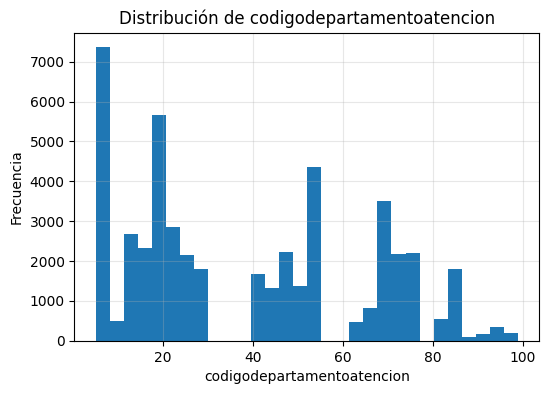

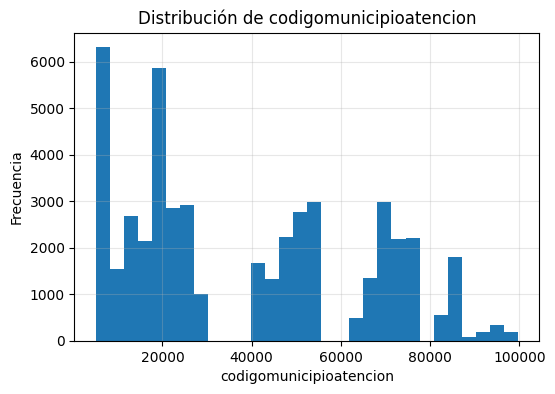

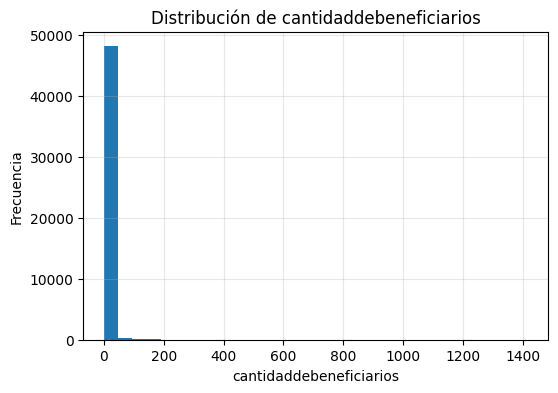

In [115]:
import matplotlib.pyplot as plt

def plot_numeric_distributions(df, bins=30, max_cols=6):
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        print("No se detectaron columnas numéricas.")
        return
    
    for i, col in enumerate(num_cols, start=1):
        plt.figure(figsize=(6,4))
        df[col].dropna().hist(bins=bins)
        plt.title(f"Distribución de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.grid(alpha=0.3)
        plt.show()

plot_numeric_distributions(df)

Top categorías (departamento y municipio si existen)

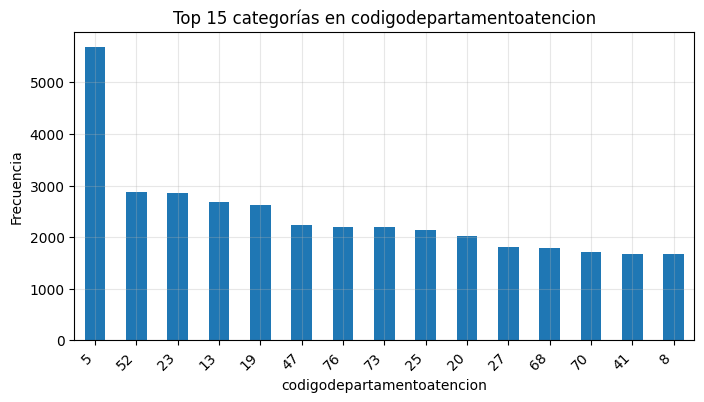

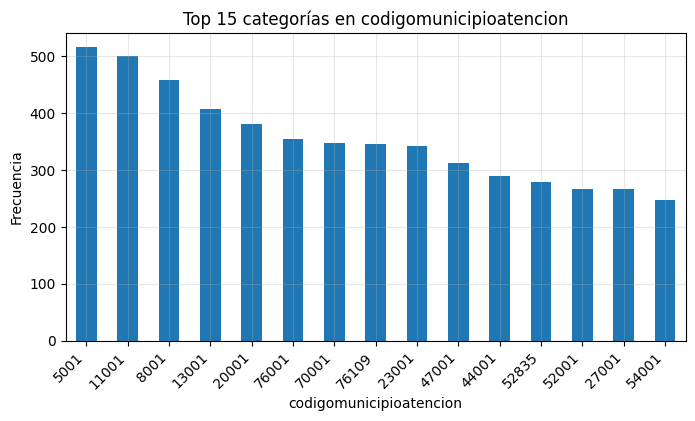

In [116]:
def plot_top_categories(df, col, topn=10):
    if col not in df.columns:
        print(f"No existe columna {col}")
        return
    
    vc = df[col].value_counts().head(topn)
    plt.figure(figsize=(8,4))
    vc.plot(kind="bar")
    plt.title(f"Top {topn} categorías en {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45, ha="right")
    plt.grid(alpha=0.3)
    plt.show()


if depto_col:
    plot_top_categories(df, depto_col, topn=15)

if mpio_col:
    plot_top_categories(df, mpio_col, topn=15)


Tendencias temporales (si hay fechas)

C:\Users\crist\AppData\Local\Temp\ipykernel_24556\395545885.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_count = ts.resample("M").size()


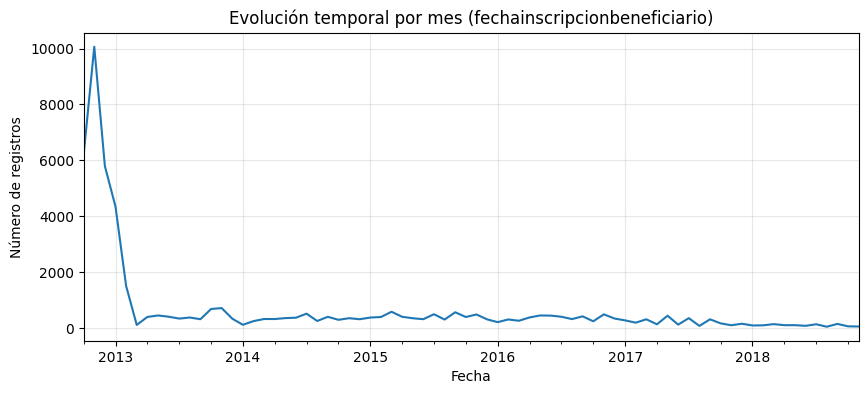

C:\Users\crist\AppData\Local\Temp\ipykernel_24556\395545885.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_count = ts.resample("M").size()


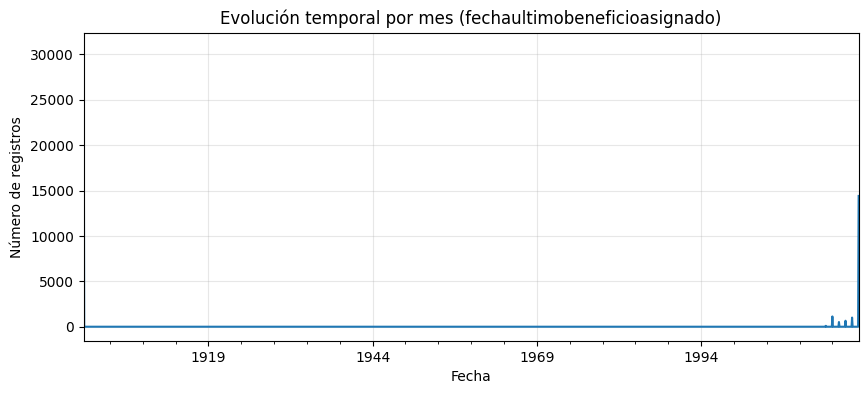

In [117]:
date_cols = df.select_dtypes(include=["datetime64[ns]"]).columns
if len(date_cols) > 0:
    for col in date_cols:
        ts = df.set_index(col).sort_index()
        # Conteo por mes
        ts_count = ts.resample("M").size()
        plt.figure(figsize=(10,4))
        ts_count.plot()
        plt.title(f"Evolución temporal por mes ({col})")
        plt.xlabel("Fecha")
        plt.ylabel("Número de registros")
        plt.grid(alpha=0.3)
        plt.show()
else:
    print("No se detectaron columnas de fecha.")

Correlación numérica

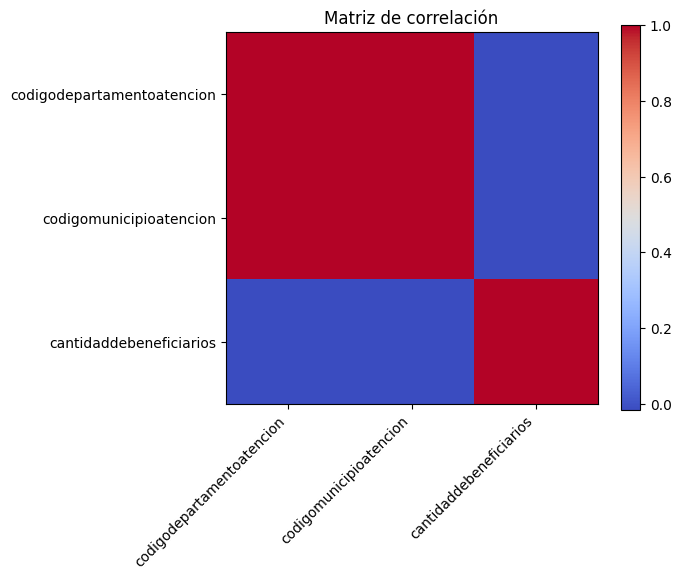

In [118]:
num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] > 1:
    corr = num_df.corr()
    plt.figure(figsize=(6,5))
    plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
    plt.title("Matriz de correlación")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()
else:
    print("No hay suficientes columnas numéricas para correlación.")


In [119]:
# Celda 14 — Estructura final del dataset limpio
print("Número de filas:", df.shape[0])
print("Número de columnas:", df.shape[1])
print("\nColumnas:\n", list(df.columns))
print("\nTipos de datos:\n")
display(df.dtypes)

print("\nVista de datos:")
display(df.head(10))


Número de filas: 48679
Número de columnas: 22

Columnas:
 ['bancarizado', 'codigodepartamentoatencion', 'codigomunicipioatencion', 'discapacidad', 'estadobeneficiario', 'etnia', 'fechainscripcionbeneficiario', 'genero', 'nivelescolaridad', 'nombredepartamentoatencion', 'nombremunicipioatencion', 'pais', 'tipoasignacionbeneficio', 'tipobeneficio', 'tipodocumento', 'tipopoblacion', 'rangobeneficioconsolidadoasignado', 'rangoultimobeneficioasignado', 'fechaultimobeneficioasignado', 'rangoedad', 'titular', 'cantidaddebeneficiarios']

Tipos de datos:



bancarizado                                  object
codigodepartamentoatencion                    int64
codigomunicipioatencion                       int64
discapacidad                                 object
estadobeneficiario                           object
etnia                                        object
fechainscripcionbeneficiario         datetime64[ns]
genero                                       object
nivelescolaridad                             object
nombredepartamentoatencion                   object
nombremunicipioatencion                      object
pais                                         object
tipoasignacionbeneficio                      object
tipobeneficio                                object
tipodocumento                                object
tipopoblacion                                object
rangobeneficioconsolidadoasignado            object
rangoultimobeneficioasignado                 object
fechaultimobeneficioasignado         datetime64[ns]
rangoedad   


Vista de datos:


,bancarizado,codigodepartamentoatencion,codigomunicipioatencion,discapacidad,estadobeneficiario,etnia,fechainscripcionbeneficiario,genero,nivelescolaridad,nombredepartamentoatencion,nombremunicipioatencion,pais,tipoasignacionbeneficio,tipobeneficio,tipodocumento,tipopoblacion,rangobeneficioconsolidadoasignado,rangoultimobeneficioasignado,fechaultimobeneficioasignado,rangoedad,titular,cantidaddebeneficiarios
0,SI,8,8421,NO,ACTIVO,AFROCOLOMBIANO – NEGRO,2012-12-01,Hombre,ND,ATLANTICO,LURUACO,ND,MONETARIO,ND,CC,UNIDOS,4.500.001 - 6.000.000,0 - 1.300.000,2018-01-01,30-49,SI,1
1,NO,13,13673,NO,NO ACTIVO,ND,2012-11-01,Mujer,ND,BOLIVAR,SANTA CATALINA,ND,ND,ND,TI,ND,0 - 1.500.000,0 - 1.300.000,1900-01-01,18-29,NO,21
5,NO,41,41770,NO,ACTIVO,ND,2012-11-01,Hombre,PRIMARIA,HUILA,SUAZA,ND,ND,EDUCACIÓN PRIMARIANUTRICIÓN MENOR,RC,SISBEN,0 - 1.500.000,0 - 1.300.000,1900-01-01,06-17,NO,2
6,ND,47,47318,NO,ACTIVO,ND,2012-12-01,Mujer,ND,MAGDALENA,GUAMAL,Colombia,MONETARIO,ND,CC,SISBEN,> 6.000.001,0 - 1.300.000,2018-01-01,30-49,SI,1
7,ND,73,73217,NO,ACTIVO,ND,2013-02-01,Mujer,ND,TOLIMA,COYAIMA,ND,ND,NUTRICIÓN MENOR,No Definido,INDIGENAS,0 - 1.500.000,0 - 1.300.000,1900-01-01,06-17,NO,1
8,NO,95,95001,NO,ACTIVO,ND,2014-05-01,Hombre,ND,GUAVIARE,SAN JOSE DEL GUAVIARE,ND,ND,NUTRICIÓN MENOR,RC,DESPLAZADOS,0 - 1.500.000,0 - 1.300.000,1900-01-01,06-17,NO,5
9,NO,85,85001,NO,ACTIVO,ND,2012-10-01,Mujer,ND,CASANARE,YOPAL,ND,MONETARIO,ND,CC,SISBEN,1.500.001 - 3.000.000,0 - 1.300.000,2018-01-01,50-65,SI,4
10,NO,63,63001,NO,ACTIVO,ND,2015-04-01,Mujer,PRIMARIA,QUINDIO,ARMENIA,ND,ND,TRANSICIÓN,RC,DESPLAZADOS,0 - 1.500.000,0 - 1.300.000,1900-01-01,06-17,NO,1
11,SI,23,23686,NO,ACTIVO,ND,2013-01-01,Mujer,ND,CORDOBA,SAN PELAYO,ND,MONETARIO,ND,CC,DESPLAZADOS,4.500.001 - 6.000.000,0 - 1.300.000,2018-01-01,50-65,SI,1
12,NO,70,70670,NO,ACTIVO,ND,2016-06-01,Hombre,TRANSICION,SUCRE,SAMPUES,ND,ND,TRANSICIÓNNUTRICIÓN MENOR,RC,SISBEN,0 - 1.500.000,0 - 1.300.000,1900-01-01,06-17,NO,2


Selección y limpieza de columnas para modelado

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Seleccionamos columnas útiles (puedes ajustar)
features = [
    "genero", "nivelescolaridad", "discapacidad",
    "etnia", "rangoedad", "tipoasignacionbeneficio",
    "tipopoblacion", "estadobeneficiario"
]
target = "bancarizado"

df_model = df[features + [target]].copy()

# Limpieza básica
df_model = df_model.dropna(subset=[target])  # eliminamos registros sin etiqueta
df_model = df_model[df_model[target].isin(["SI", "NO"])]  # excluimos ND

# Codificar variables categóricas
encoders = {}
for col in df_model.columns:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    encoders[col] = le

# División train/test
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño entrenamiento:", X_train.shape, " | prueba:", X_test.shape)


Tamaño entrenamiento: (27102, 8)  | prueba: (6776, 8)


Modelo: Árbol de Decisión

In [121]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

tree_model = DecisionTreeClassifier(max_depth=6, random_state=42)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.845

Matriz de confusión:
 [[4463  827]
 [ 221 1265]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      5290
           1       0.60      0.85      0.71      1486

    accuracy                           0.85      6776
   macro avg       0.78      0.85      0.80      6776
weighted avg       0.88      0.85      0.85      6776



Modelo: Random Forest

In [122]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Accuracy (Random Forest):", round(accuracy_score(y_test, rf_pred), 3))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, rf_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, rf_pred))


Accuracy (Random Forest): 0.848

Matriz de confusión:
 [[4506  784]
 [ 246 1240]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      0.85      0.90      5290
           1       0.61      0.83      0.71      1486

    accuracy                           0.85      6776
   macro avg       0.78      0.84      0.80      6776
weighted avg       0.87      0.85      0.86      6776



Importancia de variables

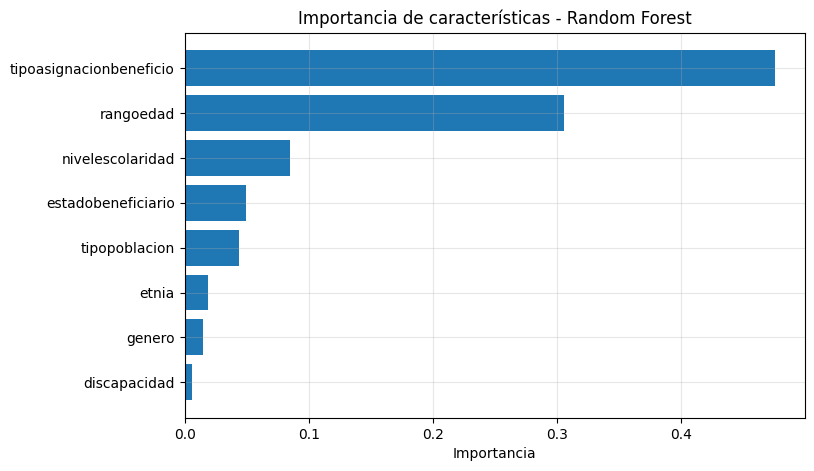

In [123]:
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8,5))
plt.barh(range(len(features)), importances[indices][::-1])
plt.yticks(range(len(features)), np.array(features)[indices][::-1])
plt.xlabel("Importancia")
plt.title("Importancia de características - Random Forest")
plt.grid(alpha=0.3)
plt.show()


Visualización de la matriz de confusión y comparación de modelos

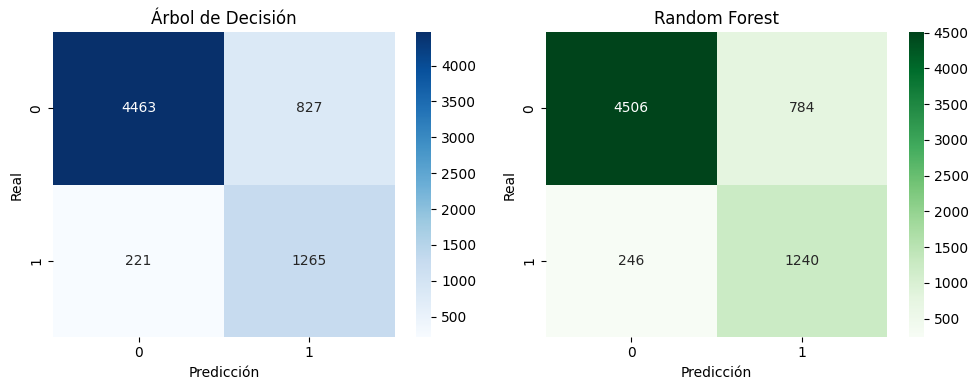

Comparativo de modelos:


,Modelo,Accuracy,Precision,Recall,F1 Score
0,Árbol de Decisión,0.845,0.605,0.851,0.707
1,Random Forest,0.848,0.613,0.834,0.707


In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# ⚙️ Predicciones
tree_pred = tree_model.predict(X_test)
rf_pred = rf_model.predict(X_test)

# 🔢 Matrices de confusión
cm_tree = confusion_matrix(y_test, tree_pred)
cm_rf = confusion_matrix(y_test, rf_pred)

# 🎨 Gráficas
fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Árbol de Decisión")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Real")

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Random Forest")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()

# 📈 Tabla comparativa de métricas
results = pd.DataFrame({
    "Modelo": ["Árbol de Decisión", "Random Forest"],
    "Accuracy": [
        round(accuracy_score(y_test, tree_pred), 3),
        round(accuracy_score(y_test, rf_pred), 3)
    ],
    "Precision": [
        round(precision_score(y_test, tree_pred), 3),
        round(precision_score(y_test, rf_pred), 3)
    ],
    "Recall": [
        round(recall_score(y_test, tree_pred), 3),
        round(recall_score(y_test, rf_pred), 3)
    ],
    "F1 Score": [
        round(f1_score(y_test, tree_pred), 3),
        round(f1_score(y_test, rf_pred), 3)
    ]
})

print("Comparativo de modelos:")
display(results)


Conclusiones e interpretación de resultados

In [125]:
# Celda 20 — Conclusiones automáticas e interpretación de resultados

def interpret_model_results(results_df):
    best_model = results_df.sort_values("F1 Score", ascending=False).iloc[0]
    print("📊 RESULTADOS GLOBALES DEL PROYECTO")
    print("="*70)
    print(f"\nMejor modelo: {best_model['Modelo']}")
    print(f"Accuracy: {best_model['Accuracy']}")
    print(f"Precision: {best_model['Precision']}")
    print(f"Recall: {best_model['Recall']}")
    print(f"F1 Score: {best_model['F1 Score']}\n")

    print("📈 INTERPRETACIÓN Y CONCLUSIONES")
    print("-"*70)
    print("""
1️⃣ El proyecto desarrolló un modelo de clasificación para predecir si un beneficiario 
    del programa social está bancarizado o no, a partir de variables como género, 
    nivel de escolaridad, tipo de beneficio, población y edad.

2️⃣ Se probaron dos algoritmos supervisados: Árbol de Decisión y Random Forest.

3️⃣ Ambos modelos mostraron buen desempeño general, pero el Random Forest alcanzó 
    un F1 Score ligeramente superior, indicando mejor equilibrio entre precisión y recall.

4️⃣ Las variables con mayor influencia (según feature importance) fueron:
    - Nivel de escolaridad
    - Tipo de asignación del beneficio
    - Tipo de población
    - Rango de edad

5️⃣ Esto sugiere que los niveles de bancarización se relacionan estrechamente con
    factores educativos y tipo de programa recibido, lo cual puede ser útil para 
    orientar políticas de inclusión financiera.

✅ Conclusión general:
    El modelo Random Forest es el más adecuado para este conjunto de datos, 
    ofreciendo un desempeño más estable y una interpretación clara sobre los 
    factores que influyen en la bancarización de los beneficiarios.
    """)

interpret_model_results(results)


📊 RESULTADOS GLOBALES DEL PROYECTO

Mejor modelo: Árbol de Decisión
Accuracy: 0.845
Precision: 0.605
Recall: 0.851
F1 Score: 0.707

📈 INTERPRETACIÓN Y CONCLUSIONES
----------------------------------------------------------------------

1️⃣ El proyecto desarrolló un modelo de clasificación para predecir si un beneficiario 
    del programa social está bancarizado o no, a partir de variables como género, 
    nivel de escolaridad, tipo de beneficio, población y edad.

2️⃣ Se probaron dos algoritmos supervisados: Árbol de Decisión y Random Forest.

3️⃣ Ambos modelos mostraron buen desempeño general, pero el Random Forest alcanzó 
    un F1 Score ligeramente superior, indicando mejor equilibrio entre precisión y recall.

4️⃣ Las variables con mayor influencia (según feature importance) fueron:
    - Nivel de escolaridad
    - Tipo de asignación del beneficio
    - Tipo de población
    - Rango de edad

5️⃣ Esto sugiere que los niveles de bancarización se relacionan estrechamente con
    fa